<a href="https://colab.research.google.com/github/Taedriel/ZSL-v2/blob/googleImageFSL/pipeline.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#---INSTALL---

In [ ]:
!yes | pip install -U --quiet selenium scikit-learn-intelex Pillow sklearn
!cd "./drive/MyDrive/Colab Notebooks/pipeline" && pip install -r --quiet requirements.txt

!apt install chromium-chromedriver
!cp /usr/lib/chromium-browser/chromedriver /usr/bin
import sys
sys.path.insert(0,'/usr/lib/chromium-browser/chromedriver')

#--- CONSTANT DEFINITION AND IMPORT ---

In [14]:
import numpy as np
import matplotlib.pyplot as plt
import os, itertools, shutil, requests, webbrowser, urllib.request, time, random
import PIL.Image
from matplotlib.patches import Rectangle

from math import trunc

from IPython.core.display import Image
from statistics import mean, pstdev
from selenium import webdriver
from bs4 import BeautifulSoup 

import torch
from torch import nn, optim
import torch.nn.functional as F
from torchvision import transforms, utils
from torchvision.models import resnet18, resnet50
from sklearn.metrics import classification_report, confusion_matrix

from tqdm import tqdm

In [15]:
PATH = "/content/drive/MyDrive/Colab Notebooks/pipeline/"
PATH_IMAGES = "/content/drive/MyDrive/Colab Notebooks/pipeline/images/"
PATH_MODEL = "/content/drive/MyDrive/Colab Notebooks/pipeline/model/"

globalSize = 20
LEN_FOR_ONE_SCROLL = 20

N_WAY = 5
N_SHOT = 5
N_QUERY = 15

batchSize = 125

#--- UTILS ---

In [19]:
def createListOfClasses(classesFile):

  """
  get set of all classes to be used in the support set from Ismael's text file
  """

  classes = []
  index=0

  for animal in classesFile.readlines():
    animal = animal.strip("\n").replace(" ", "")
    classes.append(animal)

  return classes

In [20]:
def getUa(mesurements, k=1):

  """
  get mean and incertitude from a list of mesurements, the first element in the list
  must be the title of the experiement.
  """

  title = mesurements[0]
  l = mesurements[1:]
  inv_n = 1.0/(len(l)-1)
  inv_ns = 1.0/pow(len(l), 0.5)
  m_ = round(mean(l), 2)
  dm2 = [pow(mi - m_, 2) for mi in l]
  pstd = pow(inv_n*sum(dm2), 0.5)
  u = round(k*pstd*inv_ns, 2)
  
  return title+str(m_) + "% +- " + str(u) + " (with 95% confidence)" if k!=1 else "", m_, u

def getUaList(listOfExperiences, k=1):

  for mesurements in listOfExperiences:
    string, m_, u = getUa(mesurements, k)
    print(string)

In [21]:
def getOnlyImages(set_):
  justSet = []
  for class_ in set_:
    for image in class_:
      justSet.append(image[0])

  return torch.stack(justSet)

def plot_images(images, title, images_per_row):
  plt.figure()
  plt.title(title)
  plt.imshow(utils.make_grid(images, nrow=images_per_row).permute(1, 2, 0))

In [22]:
def saveFile(filename, data):
  file = open(PATH_MODEL+filename, "w+")
  for d in data:
    file.write(str(d)+"\n")
  file.close()

def showRegression(rangeOfData, data, degree):
  coef = np.polyfit(rangeOfData, data, degree)
  poly1d_fn = np.poly1d(coef) 
  plt.plot(rangeOfData, data, '-yo', rangeOfData, poly1d_fn(rangeOfData), '--k')
  plt.show()
  print("regression polynome :\n")
  print(np.poly1d(poly1d_fn))
  print("started at", data[0], "and ended at", data[-1])
  print("\n")

def showData(data, title, degree, saveInfo=[False, ""]):

  path = saveInfo[1]
  if saveInfo[0]:
    saveFile(path, data)

  numberOfIteration = range(0, len(data))

  plt.plot(numberOfIteration, data)
  plt.title(title)
  plt.show()
  showRegression(numberOfIteration, data, degree)

In [23]:
def getMatrixReport(labels, predicted_labels):
    print("\n")
    listOfClasses = list(dict.fromkeys(labels))
    res = classification_report(labels, predicted_labels, target_names=["c"+str(i) for i in range(1, len(listOfClasses)+1)],  output_dict=True)
    return res, res['accuracy'], confusion_matrix(labels, predicted_labels)

In [24]:
def numberInInterval(interval, range_):
  in_ = 0
  minX = range_[0]
  maxX = range_[1]
  for x in interval:
    if x >= minX and x < maxX:
      in_+=1
    
    if x == 1 and maxX == 1:
      in_+=1

  return in_

def getDistributionOnPred(correctPredictions, bins):
  NumberDist = []
  for elem in bins:
    NumberDist.append(100*numberInInterval(correctPredictions, elem)/len(correctPredictions))

  return NumberDist

def createHistogramPreds(correctPredictions, title):

  bins = [(i*0.1, (i+1)*0.1) for i in range(0, 10)]
  NumberDist = getDistributionOnPred(correctPredictions, bins)

  fig, ax = plt.subplots()
  for i, percentage in enumerate(NumberDist):
    ax.add_patch(Rectangle((0.1*i, 0), 0.1, percentage, edgecolor='black'))
  plt.ylim(int(max(NumberDist))+2)
  plt.gca().invert_yaxis()
  plt.xlabel(title)
  plt.ylabel("number of predictions in %")
  plt.show()

  return NumberDist

#--- IMAGE RETRIEVAL FUNCTIONS ---

In [43]:
"""
thumbnail / jpg (compression) may be an issue
"""

def getParser(classeName):

  site = 'https://www.google.com/search?tbm=isch&q='+classeName

  chrome_options = webdriver.ChromeOptions()
  chrome_options.add_argument('--headless')
  chrome_options.add_argument('--no-sandbox')
  chrome_options.add_argument('--disable-dev-shm-usage')

  driver = webdriver.Chrome('chromedriver', options=chrome_options)
  driver.get(site)
  driver.execute_script("window.scrollBy(0, document.body.scrollHeight)")
  soup = BeautifulSoup(driver.page_source, 'html.parser')
  driver.close()

  return soup


def getImages(classes):

  imagesNumber = 0

  shutil.rmtree(PATH_IMAGES, ignore_errors=False)
  os.makedirs(PATH_IMAGES)

  print("downloading images...")

  for classe in tqdm(classes):

    try:
      classeName = classe.replace(" ", "")
      os.makedirs(PATH_IMAGES+classeName)

      soup = getParser(classeName)
      img_tags = soup.find_all("img", class_="rg_i")

      for index in range(0, len(img_tags)):
        try:
            urllib.request.urlretrieve(img_tags[index]['src'], PATH_IMAGES+classeName+"/"+str(classeName+str(index))+".jpg")
            imagesNumber+=1
        except Exception as e:
            pass
    except:
      pass

  return imagesNumber

def getClassesImagesURLLIB(classes, download=True):

  imagesNumber = 0

  if download:
    imagesNumber = getImages(classes)
  
  print("\n"+str(imagesNumber) + " images were downloaded. " + str(imagesNumber/len(classes)) + " per classes")

In [26]:
classesFile = open(PATH_MODEL+"animals.txt")
classes = createListOfClasses(classesFile)
print("classes :", classes)

classes : ['Aardvark', 'Aardwolf', 'Africanbuffalo', 'Africanelephant', 'Africanleopard', 'Albatross', 'Alligator', 'Alpaca', 'Americanrobin', 'Amphibian', 'Anaconda', 'Angelfish', 'Anglerfish', 'Ant', 'Anteater', 'Antelope', 'Antlion', 'Ape', 'Aphid']


#--- DATASET ---

In [3]:
def getNrandomClassesPaths(path, listClasses, n_way):

  if n_way == len(listClasses):
    return listClasses

  paths = []
  for i in range(0, n_way):
    ridx = random.randint(0, len(listClasses)-1)
    paths.append(path+listClasses[ridx]+"/")
    listClasses.remove(listClasses[ridx])

  return paths

In [4]:
imageResize = (224, 224)

def getImageTensor(path):
  convertCUBLike = transforms.Compose([
                                transforms.ToTensor(),
                                transforms.Normalize((0, 0, 0), (1, 1, 1))
                              ])
  convertOmni = transforms.Compose([
                                transforms.Grayscale(num_output_channels=3),
                                transforms.ToTensor(),
                                transforms.Normalize((0, 0, 0), (1, 1, 1))
                              ])
  
  return convertCUBLike(PIL.Image.open(path).resize(imageResize))

##--- For cleaning ---

In [5]:
# set is as follows : 
"""
[
  [(S1,1; Q1,1), (S1,2; Q1,2), ..., (S1,n; Q1,n)],
  [(S2,1; Q2,1), (S2,2; Q2,2), ..., (S2,n; Q2,n)]
   .                  .                    .
   .                   .                   .
   .                    .                  .
   .                     .                 .
   .                      .                .
  [(Sm,1; Qm,1), (Sm,2; Qm,2), ..., (Sm,n; Qm,n)]
]

where, 

(Si,j; Qi,j) = ( [(I, c), (I, c), ..., (I, c), (I, c)], [(I, c)] )
"""

def getFolderTensorsForCleaning(path, label, q_index):

  images = os.listdir(path)

  query = (getImageTensor(path+images[q_index]), label)
  images.remove(images[q_index])

  support = []
  for image in images:
    support.append((getImageTensor(path+image), label))

  return support, query

def getSetOfCleaningSets(path, listClass):

  MetaSet = []
  ImageNameSet = []
  for class_ in listClass:

    Set_i = []
    for q_index in range(0, len(os.listdir(path+class_+"/"))):
      supportSet, querySet = getFolderTensorsForCleaning(path+class_+"/", 0, q_index)
      Set_i.append((supportSet, querySet))
    ImageNameSet.append([path+class_+"/"+image for image in os.listdir(path+class_+"/")])

    MetaSet.append(Set_i)

  return MetaSet, ImageNameSet

##--- For training in FSL ---

In [6]:
# each set is as follows : 
"""
[
  [(I, c), (I, c), ..., (I, c), (I, c)],
  [(I, c), (I, c), ..., (I, c), (I, c)],
   .          .                    .
   .            .                  .
   .              .                .
   .                .              .
                      .            .
  [(I, c), (I, c), ..., (I, c), (I, c)]
]
"""

def getFolderTensorsForTraining(path, supportNumber, queryNumber, label):

  images = os.listdir(path)
  support_i, query_i = [], []

  for i in range(0, supportNumber):
    ridx = random.randint(0, len(images)-1)
    support_i.append( (getImageTensor(path+images[ridx]), label) )
    images.remove(images[ridx])
  
  for i in range(0, queryNumber):
    ridx = random.randint(0, len(images)-1)
    query_i.append( (getImageTensor(path+images[ridx]), label) )
    images.remove(images[ridx])

  return support_i, query_i

def getSets(paths, supportNumber, queryNumber):

  supportSet, querySet = [], []
  for label, path in enumerate(paths):
    Si, Qi = getFolderTensorsForTraining(path, supportNumber, queryNumber, label)
    supportSet.append(Si)
    querySet.append(Qi)

  return supportSet, querySet

##--- PAIR GENERATION ---

In [7]:
def getPair(c1, i, c2, j, setOfImages):

  I1 = setOfImages[c1][i][0]
  I2 = setOfImages[c2][j][0]
  s = 1.0 if c1 == c2 else 0.0

  return I1, I2, s

"""
For both PP and NP
compute cartesian product of set (without doublons).
For PP the sets are horizontal (images of same class)
For NP the sets are vertical (iamges of different class)

possible bias because (theorically) PP = NP ?
"""

"""
[
  [(I, c), (I, c), ..., (I, c), (I, c)],
  [(I, c), (I, c), ..., (I, c), (I, c)],
   .          .                    .
   .            .                  .
   .              .                .
   .                .              .
                      .            .
  [(I, c), (I, c), ..., (I, c), (I, c)]
]
"""

def getPP(setOfImages):

  PP = []
  for set_ in range(0, N_WAY):
    for offset in range(0, N_SHOT):
      for other in range(offset, N_SHOT):
        PP.append(getPair(set_, offset, set_, other, setOfImages))

  return PP

def getNP(setOfImages):

  NP = []
  for set_ in range(0, N_SHOT):
    for offset in range(0, N_WAY):
      for other in range(offset+1, N_WAY):
        NP.append(getPair(offset, set_, other, set_, setOfImages))

  return NP


def generatePNPairs(setOfImages):

  PP, NP = [], []
  PP = getPP(setOfImages)
  NP = getNP(setOfImages)

  SET = PP + NP
  random.shuffle(SET)
  return SET

In [8]:
def getIndexes(setOfImages, nbClasses):

  nbEx = len(setOfImages[0])
  ci1, e1 = random.randint(0, nbClasses-1), random.randint(0, nbEx-1) 
  ci2, e2 = random.randint(0, nbClasses-1), random.randint(0, nbEx-1)

  return ci1, ci2, e1, e2

def getRandomPair(setOfImages, cleaning=False):

  nbClasses = len(setOfImages)
  ci1, ci2, e1, e2 = getIndexes(setOfImages, nbClasses)
  I1, I2, s = 0, 0, 0

  if cleaning:
      I1, I2 = torch.stack([setOfImages[e1][0]]), torch.stack([setOfImages[e2][0]])
      s = 1.0
  else:
    I1, I2 = torch.stack([setOfImages[ci1][e1][0]]), torch.stack([setOfImages[ci2][e2][0]])
    s = 1.0 if ci1 == ci2 else 0.0

  return I1, I2, s

#--- NETWORK ---

In [ ]:
# taken from https://github.com/fangpin/siamese-pytorch/blob/master/model.py and modified

"""
I1 --> CNN --> u
                \
                  |u-v| --> NN --> x --> s(x) --> L(.,.)
                /
I2 --> CNN --> v
"""

cuda_ = True

backbone = resnet50(pretrained=True)
modules=list(backbone.children())[:-1]
combination = lambda u, v: torch.abs(u-v)      

def get_vector(image):

  image = image.cuda() if cuda_ else image
  return torch.flatten(backbone(image))

def createCombinedVector(I1, I2):

  u = get_vector(I1)
  v = get_vector(I2)
  return combination(u, v)

class Siamese(nn.Module):

  def __init__(self):
    super(Siamese, self).__init__()
    self.enter = 2048
    self.hidden = 1024
    
    self.metric = nn.Sequential(nn.Linear(self.enter, self.hidden), nn.ReLU(),
                                
                                nn.Linear(self.hidden, self.hidden), nn.ReLU(),
                                nn.Linear(self.hidden, self.hidden), nn.ReLU(),

                                nn.Linear(self.hidden, 1)) 

  def forward(self, w):
    out = self.metric(w)
    out_normalized = torch.sigmoid(out)

    return out_normalized


if cuda_:
  backbone=nn.Sequential(*modules).cuda() 
  model = Siamese().cuda()
else:
  backbone=nn.Sequential(*modules)
  model = Siamese()

In [ ]:
reset = False

if reset:
  for layer in model.children():
    if hasattr(layer, 'reset_parameters'):
      layer.reset_parameters()

In [ ]:
ADAM = True

if ADAM:
  optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
else:
  torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9, weight_decay=0.5)

In [89]:
def saveModel(epoch, loss_value):

  torch.save({
  'epoch': epoch,
  'model_state_dict': model.state_dict(),
  'optimizer_state_dict': optimizer.state_dict(),
  'loss': loss_value
  }, "/content/drive/MyDrive/Colab Notebooks/pipeline/model/SNForCleaning.pt")

In [88]:
def loadModel(model_name):
  checkpoint = torch.load(PATH_MODEL+model_name)
  model.load_state_dict(checkpoint['model_state_dict'])
  optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
  epoch_ = checkpoint['epoch']
  loss_ = checkpoint['loss']

  return epoch_, loss_

#--- TRAINING FUNCTIONS ---

In [63]:
LOSS = nn.BCELoss() # nn.MSELoss() #

In [64]:
def epoch(suppSet, cleaning):

  lossForBatch = []
  for i in range(0, batchSize):

    I1, I2, s = getRandomPair(suppSet, cleaning)

    # talk to feeham :
    """
    where does your training start ? => NN.
    but start with w creation. Does it influence ?
    """

    I1, I2 = getImages(I1, I2)
    w = createCombinedVector(I1, I2)
    out = model(w)
    s = torch.tensor([s]).cuda() if cuda_ else torch.tensor([s])

    optimizer.zero_grad()
    loss = LOSS(out, s)
    loss.backward()
    optimizer.step()
    lossForBatch.append(loss.item())

  return lossForBatch


def training(supportSet, cleaning, epoch_res=0, loss_res=0, set_i=0):

  numberOfEpochs = 70-epoch_res
  valFreq = 10

  losses = [loss_res] if loss_res != 0 else []
  
  model.train()
  for epoch_i in tqdm(range(0, numberOfEpochs), desc="Traning on Set "+str(set_i)):

    batchLoss = epoch(supportSet, cleaning)
    mean_loss = sum(batchLoss)*1.0/len(batchLoss)
    losses.append(mean_loss)

    if epoch_i % valFreq == 0 and epoch_i != 0:
      saveModel(model, mean_loss)

  torch.save(model.state_dict(), PATH_MODEL+"SN.pt")

  return losses

#--- TESTING FUNCTIONS ---

In [80]:
def getImages(image1, image2):

  if image1.dim() < 4:
    image1 = image1.unsqueeze(0)
  
  if image2.dim() < 4:
    image2 = image2.unsqueeze(0)

  return image1, image2

In [81]:
def getFirstClassBasedOnRepresentation(predictions):

  representation = [0]*N_WAY
  for pred in predictions:
    representation[pred[0]] += 1

  return representation.index(max(representation))

def isCorrect(predictions, queryClass):

  pred_sorted = sorted(predictions, key=lambda tup: tup[-1], reverse=True)
  first_five = pred_sorted[0:5]

  predictedClassLabel = getFirstClassBasedOnRepresentation(first_five)
  similarity = int(queryClass == predictedClassLabel)
  predictionScore = first_five[0][1]

  return similarity, predictedClassLabel, predictionScore

  # first_five[0][0] # 
  #print("query is", queryClass, "and prediction is", predictedClassLabel, "similarity : ", similarity)
  #print("query is ", queryClass, " and prediction are :", list(map(lambda t: (t[0], t[1].cpu().numpy()[0]), first_five)), " similarity : ", int(queryClass == predictedClassLabel))

def evaluate(supportSet, querySet):

  triplets = []
  pred_labels = []
  query_labels = []
  correctPreds, incorrectPreds = [], []
  correctClass, correct = 0, 0
  
  model.eval()
  with torch.no_grad():

    for indexQuery, queryInfo in enumerate(list(itertools.chain(*querySet))):

      torch.cuda.empty_cache()
      query, queryClass = queryInfo

      for imageInfo in list(itertools.chain(*supportSet)):

        image, imageClass = imageInfo
        query, image = getImages(query, image)
        w = createCombinedVector(query, image)
        p = model(w)
        triplets.append((imageClass, p))
      
      areReallySimilar, imageClass, prediction = isCorrect(triplets, queryClass)
      if areReallySimilar == 1: 
        correct+=1
        correctPreds.append(prediction)
      else:
        incorrectPreds.append(prediction)

      triplets = []
      pred_labels.append(imageClass)
      query_labels.append(queryClass)

  return "\n accuracy :"+str(100.0*correct/(N_WAY*N_QUERY)), pred_labels, query_labels, correctPreds, incorrectPreds

In [1]:
def queryEvaluation(supportSet, querySet):

  triplets = []
  model.eval()
  with torch.no_grad():

    query, queryClass = querySet
    for imageInfo in list(itertools.chain(*supportSet)):

      image, imageClass = imageInfo
      query, image = getImages(query, image)
      w = createCombinedVector(query, image)
      p = model(w)
      triplets.append((imageClass, p))
    
  pred_sorted = sorted(triplets, key=lambda tup: tup[-1], reverse=True)
  first_five = pred_sorted[0:5]
  predictedClassLabel = getFirstClassBasedOnRepresentation(first_five)

  return predictedClassLabel

#--- CLEANING FUNCTIONS --- 

In [49]:
def isQueryOutsider(supportSet, querySet):
  
  preds = []
  model.eval()
  with torch.no_grad():

    query_raw = querySet[0]
    for image_raw, imageClass in supportSet:

      query, image = getImages(query_raw, image_raw)
      w = createCombinedVector(query, image)
      p = model(w)
      preds.append(p)

  return 1.0*sum(preds)/len(preds)

In [50]:
def getPredictionForOneQuery(Sij, Qij, indexSet):

  loadModel("SNForCleaning.pt")
  training(Sij, cleaning=True, set_i=indexSet) 
  p = isQueryOutsider(Sij, Qij)

  return p

def getPredictionForAllQueries(MetaSet):

  listOfClassPredictions = []
  for i, Set_i in enumerate(MetaSet):

    SetPredictions = []
    for Sij, Qij in Set_i:
      SetPredictions.append(getPredictionForOneQuery(Sij, Qij, i))
    
    listOfClassPredictions.append(SetPredictions)
    print("similarities for set ", i, SetPredictions)

  return listOfClassPredictions

In [51]:
def mult(A, P, e):

  A = list(itertools.chain(*A))
  P = list(itertools.chain(*P))

  res = []
  for ai, pi in zip(A, P):
    if pi < e: 
      res.append(ai)
  
  return res

In [52]:
def clean(ImageSet):
  for image in ImageSet:
    os.remove(image)

#--- PATH DEFINITION ---

In [33]:
CUB, IMAGES, OMNIGLOT = False, True, False
PATH_DATA = ""
listClass = []

# a simplifier + tard quand j'aurais + qu'un path
if CUB or IMAGES:
  PATH_DATA = "/content/drive/MyDrive/Colab Notebooks/pipeline/model/data/CUB/images/" if CUB else "/content/drive/MyDrive/Colab Notebooks/pipeline/images/"
  listClass = os.listdir(PATH_DATA)
elif OMNIGLOT:
  PATH_DATA = "/content/drive/MyDrive/Colab Notebooks/pipeline/model/dataO/omniglot-py/images_background/" 
  listAlphabet = os.listdir(PATH_DATA)
  choosenAlphabet = listAlphabet[random.randint(0, len(listAlphabet)-1)]
  listClass = [choosenAlphabet+"/"+char for char in os.listdir(PATH_DATA+choosenAlphabet)]

#--- TRAIN AND TEST ---

In [ ]:
supportClasses = getNrandomClassesPaths(PATH_DATA, listClass, N_WAY)
print(supportClasses)
supportSet, querySet = getSets(supportClasses, N_SHOT, N_QUERY)

In [ ]:
justSupport = getOnlyImages(supportSet)
justQuery = getOnlyImages(querySet)
plot_images(justSupport, title="support set", images_per_row=N_SHOT)
plot_images(justQuery, title="query set", images_per_row=N_QUERY)

In [ ]:
resume = False
epoch_, loss_ = 0, 0

if resume: 
  epoch_, loss_ = loadModel("model_check.pt")

In [ ]:
trainingNeeded = True
if trainingNeeded:
  losses = training(supportSet, epoch_, loss_, cleaning=False)
else:
  model.load_state_dict(torch.load(PATH_MODEL+"SN.pt"))
  print("model loaded")

In [ ]:
showData(losses, "loss during training", 3)

In [ ]:
accuracyResults, y_pred, y, correctPreds, incorrectPreds = evaluate(supportSet, querySet)

_, _, confM = getMatrixReport(y, y_pred)
print(accuracyResults)
print(confM)

# --- STATS ---

In [ ]:
listOfExperiences5 = [
                     ["(Adam, 1E-3), 3h1o (512, 240)..(240, 1)), Pre-done, 350x350, BCELoss, 70 epochs: ", 41, 40, 30.66, 34.66, 26.66],
                     ["(Adam, 1E-3), 3h1o (512, 240)..(240, 1)), Random  , 350x350, BCELoss, 70 epochs: ", 38.67, 26.67, 34.67, 38.67, 45],
                     ["(Adam, 1E-3), 3h1o (2048, 1024)..(1024, 1)), Random, 224x224, BCELoss, 70 epochs, normalized: ", 62.67, 50.67, 45.33, 54.67, 52],
                     ["(Adam, 1E-3), 3h1o (2048, 1024)..(1024, 1)), Random, 224x224, MSELoss, 70 epochs, normalized, representation, Omni ", 77.33, 77.33, 78.67, 77.33],
                     ["(Adam, 1E-3), 3h1o (2048, 1024)..(1024, 1)), Random, 224x224, MSELoss, 70 epochs, normalized, representation, Omni with reset ", 94.67, 86.67, 72],
                     ["(Adam, 1E-3), 3h1o (4096, 2048)..(2048, 1)) [use cat], Random, 224x224, BCELoss, 70 epochs, normalized, representation", 0, 0, 0, 0, 0]

                    ]
listOfExperiences6 = [
                      ["(Adam, 1E-3), 3h1o (2048, 1024)..(1024, 1)), Random, 224x224, BCELoss, 70 epochs, normalized, representation: ", 60, 53.33, 72, 46.67, 53.33, 42.67],
                      ["(Adam, 1E-3), 3h1o (2048, 1024)..(1024, 1)), Random, 224x224, BCELoss, 70 epochs, normalized, representation, Omni: ", 84, 74.67, 92, 77.33, 76, 68]
                      ]

listOfExperiences7 = [
                      ["(Adam, 1E-3), 3h1o (2048, 1024)..(1024, 1)), Random, 350x350, BCELoss, 70 epochs: ", 48, 46.67, 48, 41.33, 49, 42, 40]
                      ]

TotalList = [listOfExperiences5,
             listOfExperiences6, 
             listOfExperiences7
            ]

In [ ]:
createHistogramPreds(correctPreds, "prediction's score (correct)")
createHistogramPreds(incorrectPreds, "prediction's score (incorrect)")
createHistogramPreds(correctPreds+incorrectPreds, "total perdictions")

In [ ]:
getUaList(listOfExperiences5, 2.776)
getUaList(listOfExperiences6, 1.945)
getUaList(listOfExperiences7, 1.895)

In [ ]:
for listExp in TotalList:
  for x in listExp:
    plt.hist(x[1:])
    plt.title(x[0])
    plt.show()

#--- ACTUAL PIPELINE ---

##--- IMAGE RETRIEVAL ---

In [44]:
classesFile = open(PATH_MODEL+"animals.txt")
classes = createListOfClasses(classesFile)
print("classes :", classes)

retreivalNotDone = True
if retreivalNotDone:
  getClassesImagesURLLIB(classes, retreivalNotDone)

classes : ['Aardvark', 'Aardwolf', 'Africanbuffalo', 'Africanelephant', 'Africanleopard', 'Albatross', 'Alligator', 'Alpaca', 'Americanrobin', 'Amphibian', 'Anaconda', 'Angelfish', 'Anglerfish', 'Ant', 'Anteater', 'Antelope', 'Antlion', 'Ape', 'Aphid']
downloading images...


100%|██████████| 19/19 [00:57<00:00,  3.02s/it]


378 images were downloaded. 19.894736842105264 per classes


##--- CLEANING ---

In [45]:
MetaSet, ImageNameSet = getSetOfCleaningSets(PATH_DATA, classes)

In [47]:
listOfPreds = getPredictionForAllQueries(MetaSet)
#listOfPreds = [[random.random() for i in range(0, 20)] for j in range(0, len(classes))]

In [53]:
ImageToRemove = mult(ImageNameSet, listOfPreds, 0.6)
print(ImageToRemove)

['/content/drive/MyDrive/Colab Notebooks/pipeline/images/Aardvark/Aardvark1.jpg', '/content/drive/MyDrive/Colab Notebooks/pipeline/images/Aardvark/Aardvark4.jpg', '/content/drive/MyDrive/Colab Notebooks/pipeline/images/Aardvark/Aardvark5.jpg', '/content/drive/MyDrive/Colab Notebooks/pipeline/images/Aardvark/Aardvark6.jpg', '/content/drive/MyDrive/Colab Notebooks/pipeline/images/Aardvark/Aardvark7.jpg', '/content/drive/MyDrive/Colab Notebooks/pipeline/images/Aardvark/Aardvark9.jpg', '/content/drive/MyDrive/Colab Notebooks/pipeline/images/Aardvark/Aardvark11.jpg', '/content/drive/MyDrive/Colab Notebooks/pipeline/images/Aardvark/Aardvark12.jpg', '/content/drive/MyDrive/Colab Notebooks/pipeline/images/Aardvark/Aardvark14.jpg', '/content/drive/MyDrive/Colab Notebooks/pipeline/images/Aardvark/Aardvark15.jpg', '/content/drive/MyDrive/Colab Notebooks/pipeline/images/Aardvark/Aardvark16.jpg', '/content/drive/MyDrive/Colab Notebooks/pipeline/images/Aardvark/Aardvark19.jpg', '/content/drive/MyDri

In [54]:
clean(ImageToRemove)

##--- TRAINING ---

In [60]:
supportClasses = [PATH_DATA+class_+"/" for class_ in classes]
supportSet, _ = getSets(supportClasses, 5, 0) # to modifiy to min(len), the crucial problem is here

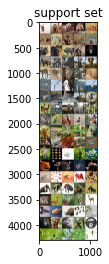

In [61]:
justSupport = getOnlyImages(supportSet)
plot_images(justSupport, title="support set", images_per_row=N_SHOT)

In [ ]:
training(supportSet, epoch_, loss_, cleaning=False)

## --- EVALUATION ---

In [ ]:
querySet = []
predictedLabel = queryEvaluation(supportSet, querySet)

In [ ]:
plot_images(querySet, title="Image of "+classes[predictedLabel], images_per_row=1) # possible error with classes[predictedLabel] to check thourougly